CESM
/glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-fields-ann.zarr

ROISST
/glade/p/cgd/oce/projects/krill-cesm-le/data/oisst-avhrr-v02r01.1982-2019_ANN.POP_gx1v6.zarr

WOA
/glade/p/cgd/oce/projects/krill-cesm-le/data/woa2018_ANN.POP_gx1v6.zarr

HadISST
/glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_ANN.POP_gx1v6.zarr

## CESM-LE SST BIAS CHECK: Annual

In [104]:
import xarray as xr
import numpy as np
import util

In [75]:
dso = xr.open_zarr('/glade/p/cgd/oce/projects/krill-cesm-le/data/HadISST_ANN.POP_gx1v6.zarr')
dso = dso.isel(nlat=slice(0, 93), time=slice(50, 150))
dso

<xarray.Dataset>
Dimensions:  (nlat: 93, nlon: 320, time: 100)
Coordinates:
    TLAT     (nlat, nlon) float64 dask.array<chunksize=(93, 160), meta=np.ndarray>
    TLONG    (nlat, nlon) float64 dask.array<chunksize=(93, 160), meta=np.ndarray>
  * time     (time) int64 1920 1921 1922 1923 1924 ... 2015 2016 2017 2018 2019
Dimensions without coordinates: nlat, nlon
Data variables:
    KMT      (nlat, nlon) int32 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA    (nlat, nlon) float64 dask.array<chunksize=(93, 160), meta=np.ndarray>
    sst      (time, nlat, nlon) float64 dask.array<chunksize=(7, 93, 80), meta=np.ndarray>

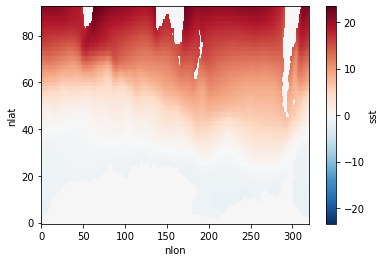

In [76]:
dso_mean = dso.sst.mean('time')
dso_mean.plot()

In [77]:
dsm = xr.open_zarr('/glade/p/cgd/oce/projects/krill-cesm-le/data/cesm-le-fields-ann.zarr')
dsm = dsm.isel(time=slice(0, 100))
dsm

<xarray.Dataset>
Dimensions:        (length: 3, member_id: 34, nlat: 93, nlon: 320, time: 100, z_t: 60, z_t_150m: 15)
Coordinates:
    KMT            (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TAREA          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    TLONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULAT           (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    ULONG          (nlat, nlon) float64 dask.array<chunksize=(93, 320), meta=np.ndarray>
    dz             (z_t) float32 dask.array<chunksize=(60,), meta=np.ndarray>
  * length         (length) float64 20.0 40.0 60.0
  * member_id      (member_id) int64 1 2 9 10 11 12 ... 35 101 102 103 104 105
  * time           (time) int64 1920 1921 1922 1923 1924 ... 2016 2017 2018 2019
  * z_t            (z_t) float32 500.0 1500.0 2500.0 ... 512502.8 537500.0
  * z_t_150m       (z_t_150m) float32 500.0 1500.0 2500.0 ... 13500.0 14500.0
Dimensions without coordinates: nlat, nlon
Data variables:
    Chl_surf       (time, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 1, 93, 320), meta=np.ndarray>
    IFRAC          (time, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 1, 93, 320), meta=np.ndarray>
    Jint_100m_DIC  (time, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 1, 93, 320), meta=np.ndarray>
    KGP            (time, length, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 3, 1, 93, 320), meta=np.ndarray>
    NPP            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 1, 93, 320), meta=np.ndarray>
    SST            (time, member_id, nlat, nlon) float64 dask.array<chunksize=(100, 1, 93, 320), meta=np.ndarray>

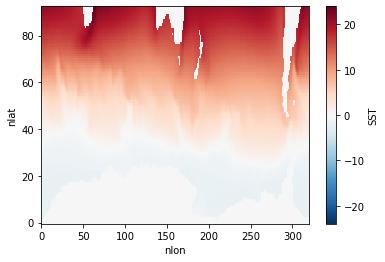

In [78]:
dsm_mean = dsm.SST.mean(['member_id', 'time'])
dsm_mean.plot()

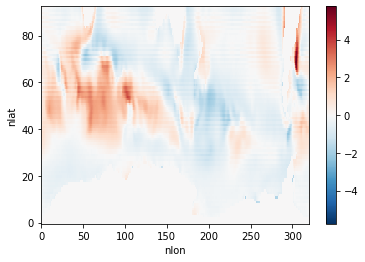

In [81]:
bias = dsm_mean - dso_mean
bias.plot()

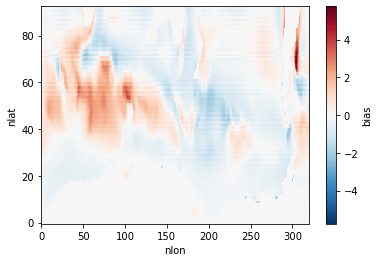

In [82]:
bias = bias.assign_coords(TLAT=dsm['TLAT'], TLONG=dsm['TLONG']).rename('bias').compute()
bias.plot()

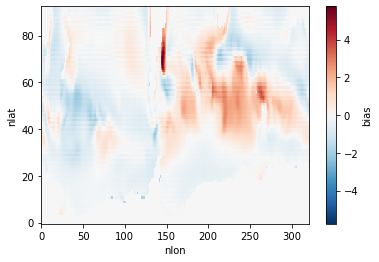

In [84]:
biasp = util.pop_add_cyclic(bias.to_dataset())
biasp.bias.plot()

In [27]:
print('mod mean: 1921-2020')
print('mean:', dsm_mean.mean().values)
print('min:', dsm_mean.min().values)
print('max:', dsm_mean.max().values)
print('obs mean')
print('mean:', dso_mean.mean().values)
print('min:', dso_mean.min().values)
print('max:', dso_mean.max().values)
print('bias')
print('mean:', bias.mean().values)
print('min:', bias.min().values)
print('max:', bias.max().values)

mod mean: 1921-2020
mean: 5.792148142310743
min: -1.8085196927395755
max: 23.9982771600922
obs mean
mean: 5.773585755073917
min: -1.7574327259776459
max: 23.347362225174276
bias
mean: 0.01856238723682487
min: -2.3313856998843843
max: 5.766072395288013


___
## Visualize Polar

In [28]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
import cartopy
import cartopy.crs as ccrs
from cartopy.util import add_cyclic_point
import cmocean
import util

In [29]:
# Plotting Standards:
class MidpointNormalize(colors.Normalize):
    """
    class to help renormalize the color scale
    """
    def __init__(self, vmin=None, vmax=None, midpoint=None, clip=False):
        self.midpoint = midpoint
        colors.Normalize.__init__(self, vmin, vmax, clip)

    def __call__(self, value, clip=None):
        # I'm ignoring masked values and all kinds of edge cases to make a simple example...
        x, y = [self.vmin, self.midpoint, self.vmax], [0, 0.5, 1]
        return np.ma.masked_array(np.interp(value, x, y))

In [30]:
# Lat Lon Source
lon = ds_obs.TLONG.values
lat = ds_obs.TLAT.values

## Plot CESM-LE

In [105]:
# What are you plotting?
to_plot = dsm
array = dsm_mean

# Make it Plottable
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'feild': array,
        'TLAT': to_plot.TLAT.compute(),
        'TLONG': to_plot.TLONG.compute() } ))

In [106]:
###########################  levels  -  norm  -  extent  -  projection  ############################    
levels = np.linspace(-2, 20, 23)
level_cont = [-1,5]

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()
###############################  Plotting Function:  'One Plot'  ###################################
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels,
                     cmap=cmocean.cm.thermal,
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='whitesmoke',
                    levels=level_cont,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    return cf

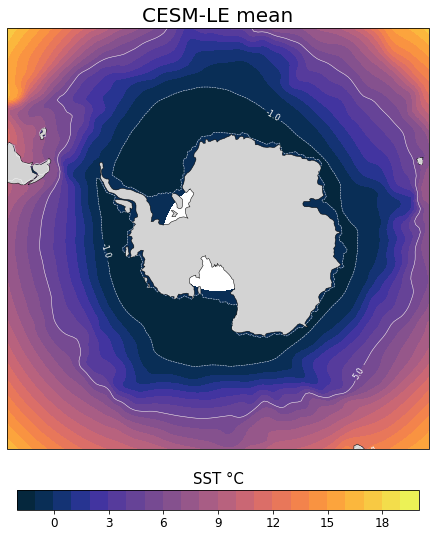

In [107]:
fig = plt.figure(figsize=(12, 10))
axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.feild)
ax.set_title('CESM-LE mean', fontsize=20)
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.tick_params(labelsize=12)
cb.ax.set_title('SST °C', fontsize=15);

## Observations

In [108]:
# What are you plotting?
to_plot = dso
array = dso_mean
# Make it Plottable
dsp = util.pop_add_cyclic(
    xr.Dataset({
        'feild': array,
        'TLAT': to_plot.TLAT.compute(),
        'TLONG': to_plot.TLONG.compute() } ))

In [109]:
###########################  levels  -  norm  -  extent  -  projection  ############################    
levels = np.linspace(-2, 20, 23)
level_cont = [-1,5]

extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]

prj = ccrs.SouthPolarStereo()

###############################  Plotting Function:  'One Plot'  ###################################
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels,
                     cmap=cmocean.cm.thermal,
                     transform=ccrs.PlateCarree())

    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='whitesmoke',
                    levels=level_cont,
                    linewidths=0.5,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    return cf

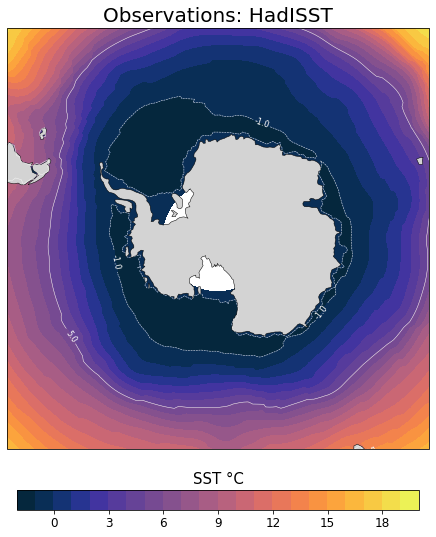

In [110]:
fig = plt.figure(figsize=(12, 10))
axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.feild)
ax.set_title('Observations: HadISST', fontsize=20)

axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.tick_params(labelsize=12)
cb.ax.set_title('SST °C', fontsize=15);

## Repeat for Bias

In [93]:
# Make it Plottable
dsp = biasp

In [99]:
np.linspace(-5, 5, 21)

array([-5. , -4.5, -4. , -3.5, -3. , -2.5, -2. , -1.5, -1. , -0.5,  0. ,
        0.5,  1. ,  1.5,  2. ,  2.5,  3. ,  3.5,  4. ,  4.5,  5. ])

In [102]:
###########################  levels  -  norm  -  extent  -  projection  ############################    
#levels_bias = np.linspace(-15.5, 2, 36)
levels_bias = np.linspace(-5, 5, 21)

norm = MidpointNormalize(midpoint=0.)
extent = ([-180, 180, -90, -50], ccrs.PlateCarree()) #[120, 260, 10, 65]
prj = ccrs.SouthPolarStereo()
###############################  Plotting Function:  'One Plot'  ###################################
def one_plot(da, lines=True):
    # filled contours
    cf = ax.contourf(dsp.TLONG, dsp.TLAT, da,
                     levels=levels_bias,
                     norm=norm,
                     cmap=cmocean.cm.balance,
                     #extend='both',
                     transform=ccrs.PlateCarree())
    # contour lines
    cs = ax.contour(dsp.TLONG, dsp.TLAT, da,
                    colors='k',
                    levels=levels_bias,
                    linewidths=0.25,
                    transform=ccrs.PlateCarree())
    if lines:
        # add contour labels
        lb = plt.clabel(cs, fontsize=8, inline=True, fmt='%r')
    # land
    land = ax.add_feature(
        cartopy.feature.NaturalEarthFeature('physical', 'land', '110m',
                                            facecolor='lightgray'))
    ax.coastlines(linewidth=0.5)
    return cf

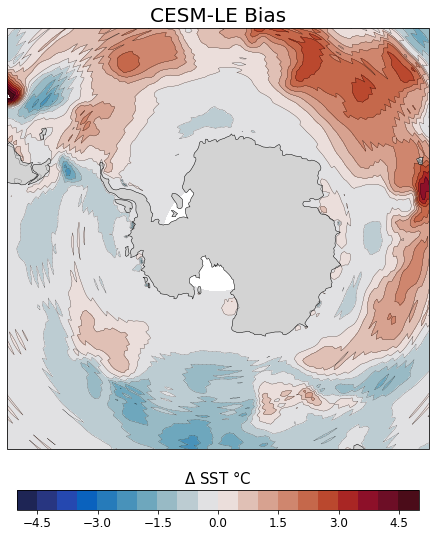

In [103]:
#BIAS
fig = plt.figure(figsize=(12, 10))
axs = []

# plot total
ax = fig.add_subplot(1, 1, 1, projection=prj)
ax.set_extent([-180, 180, -90, -50], ccrs.PlateCarree())
cf = one_plot(dsp.bias, lines=False)
ax.set_title('CESM-LE Bias', fontsize=20)
axs.append(ax)

# colorbar and labels
cb = plt.colorbar(cf, shrink=0.6, orientation='horizontal', pad=0.075, ax=axs)
cb.ax.tick_params(labelsize=12)
cb.ax.set_title('$\Delta$ SST °C', fontsize=15);